In [6]:
# Cell 1 — 先把目录里有哪些文件、文件名长什么样子，打印出来
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, random

X_TRAIN_DIR = Path(r"..\data\X_train_uDRk9z9")
X_TEST_DIR  = Path(r"..\data\X_train_uDRk9z9")
X_UNLAB_DIR = Path(r"..\data\X_unlabeled_mtkxUlo")
Y_TRAIN_CSV = Path(r"..\data\Y_train_T9NrBYo.csv")

def list_some(dir_path: Path, k=10):
    files = sorted(list(dir_path.rglob("*.npy")))
    if len(files) == 0:
        files = sorted(list(dir_path.rglob("*.NPY")))
    print(dir_path)
    print("n_files =", len(files))
    print("first few names:")
    for p in files[:k]:
        print(" ", p.name)
    return files

train_files = list_some(X_TRAIN_DIR, k=8)
test_files  = list_some(X_TEST_DIR,  k=8)
unlab_files = list_some(X_UNLAB_DIR, k=8)


..\data\X_train_uDRk9z9
n_files = 4410
first few names:
  well_1_section_0_patch_0.npy
  well_1_section_0_patch_1.npy
  well_1_section_0_patch_10.npy
  well_1_section_0_patch_11.npy
  well_1_section_0_patch_12.npy
  well_1_section_0_patch_13.npy
  well_1_section_0_patch_14.npy
  well_1_section_0_patch_15.npy
..\data\X_train_uDRk9z9
n_files = 4410
first few names:
  well_1_section_0_patch_0.npy
  well_1_section_0_patch_1.npy
  well_1_section_0_patch_10.npy
  well_1_section_0_patch_11.npy
  well_1_section_0_patch_12.npy
  well_1_section_0_patch_13.npy
  well_1_section_0_patch_14.npy
  well_1_section_0_patch_15.npy
..\data\X_unlabeled_mtkxUlo
n_files = 1980
first few names:
  well_12_section_10_patch_0.npy
  well_12_section_10_patch_1.npy
  well_12_section_10_patch_10.npy
  well_12_section_10_patch_11.npy
  well_12_section_10_patch_2.npy
  well_12_section_10_patch_3.npy
  well_12_section_10_patch_4.npy
  well_12_section_10_patch_5.npy


In [5]:
# Cell 2 — 读一个 npy 看 shape / dtype / 数值范围 / NaN
def inspect_one_npy(path: Path):
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    print("file:", path.name)
    print("shape:", x.shape, "dtype:", x.dtype)
    print("has_nan:", np.isnan(x).any(), "has_inf:", np.isinf(x).any())
    x0 = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    print("min/max/mean/std:", float(x0.min()), float(x0.max()), float(x0.mean()), float(x0.std()))
    return x0

# 随便看几个
for p in train_files[:3]:
    _ = inspect_one_npy(p)
    print("-"*60)


file: well_1_section_0_patch_0.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -330.0 345.0 0.060822610294117646 36.19590855351595
------------------------------------------------------------
file: well_1_section_0_patch_1.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -189.0 192.0 -0.02741268382352941 26.921422071942036
------------------------------------------------------------
file: well_1_section_0_patch_10.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -246.0 184.0 0.07722886029411764 26.7090272702919
------------------------------------------------------------


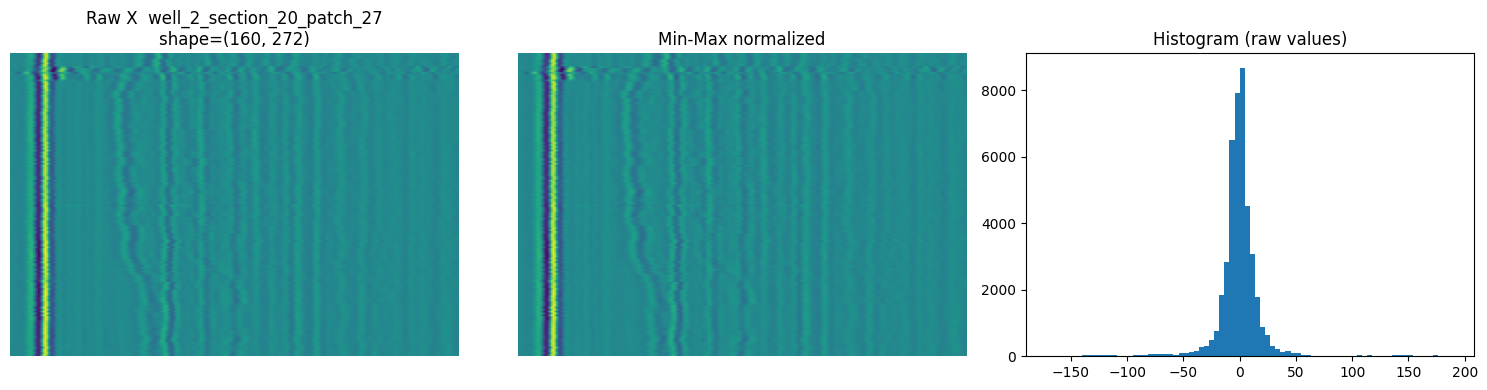

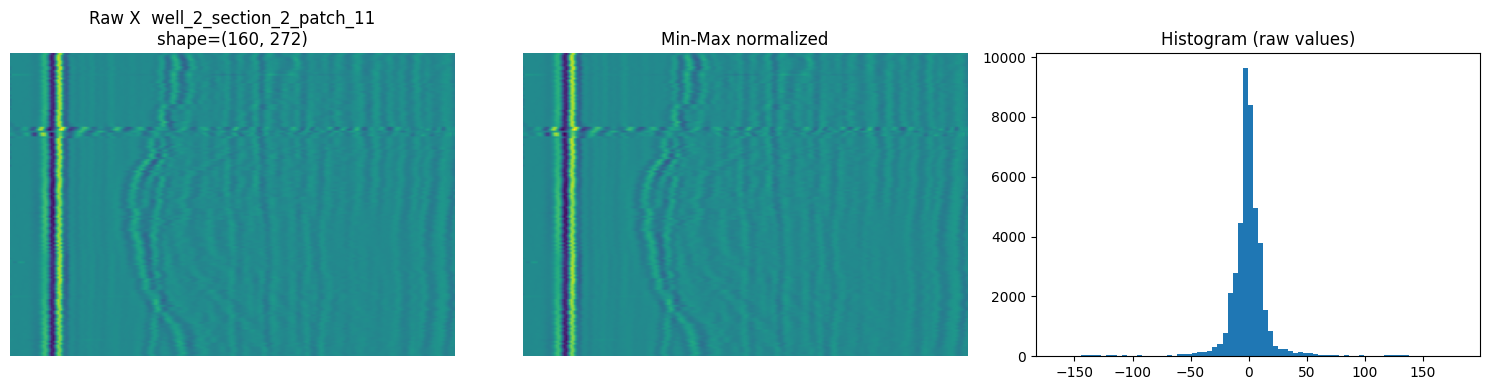

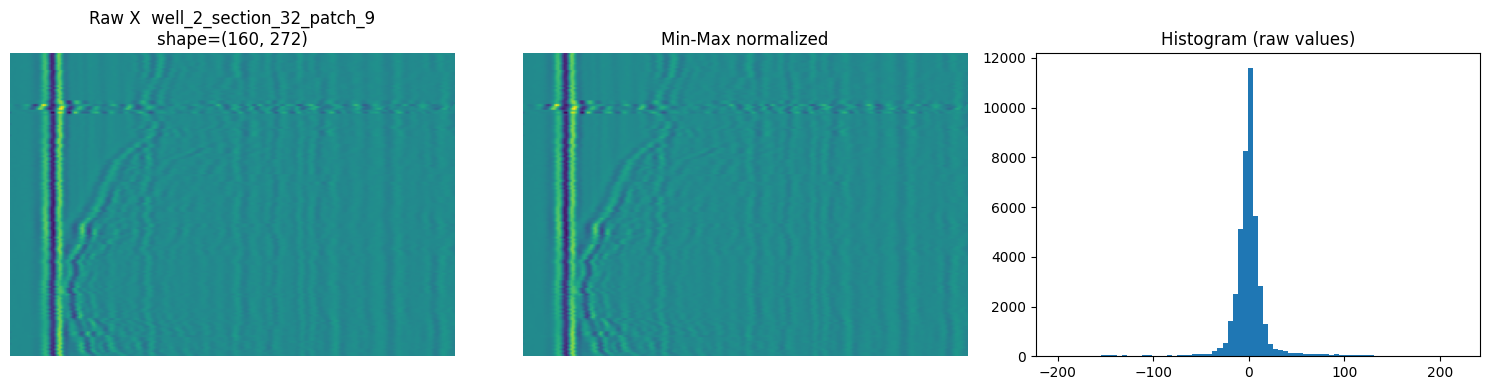

In [6]:
# Cell 3 — 把 X 画出来（原图 + min-max 归一化图 + 直方图）
def minmax_norm(x: np.ndarray) -> np.ndarray:
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        return (x - mn) / (mx - mn)
    return np.zeros_like(x, dtype=np.float32)

def show_x(path: Path):
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    xn = minmax_norm(x)

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.title(f"Raw X  {path.stem}\nshape={x.shape}")
    plt.imshow(x, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Min-Max normalized")
    plt.imshow(xn, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Histogram (raw values)")
    plt.hist(x.flatten(), bins=80)
    plt.tight_layout()
    plt.show()

# 看几张训练图
for p in random.sample(train_files, k=3):
    show_x(p)


y_df shape: (4410, 43520)
index example: well_2_section_22_patch_1


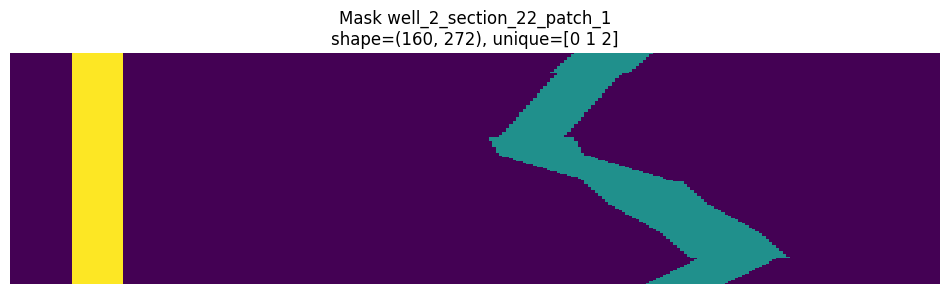

In [7]:
# Cell 4 — 读取 y_train.csv，并还原某个 patch 的 mask，看看长什么样
y_df = pd.read_csv(Y_TRAIN_CSV, index_col=0)
print("y_df shape:", y_df.shape)
print("index example:", y_df.index[0])

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]  # 去 padding
    mask = vals.reshape(160, -1)
    return mask.astype(np.int64)

def show_mask(name: str):
    row = y_df.loc[name].values
    m = restore_mask_from_row(row)
    plt.figure(figsize=(12, 3))
    plt.title(f"Mask {name}\nshape={m.shape}, unique={np.unique(m)}")
    plt.imshow(m, aspect="auto", interpolation="nearest")
    plt.axis("off")
    plt.show()
    return m

# 随便看一个 label
example_name = y_df.index[0]
_ = show_mask(example_name)


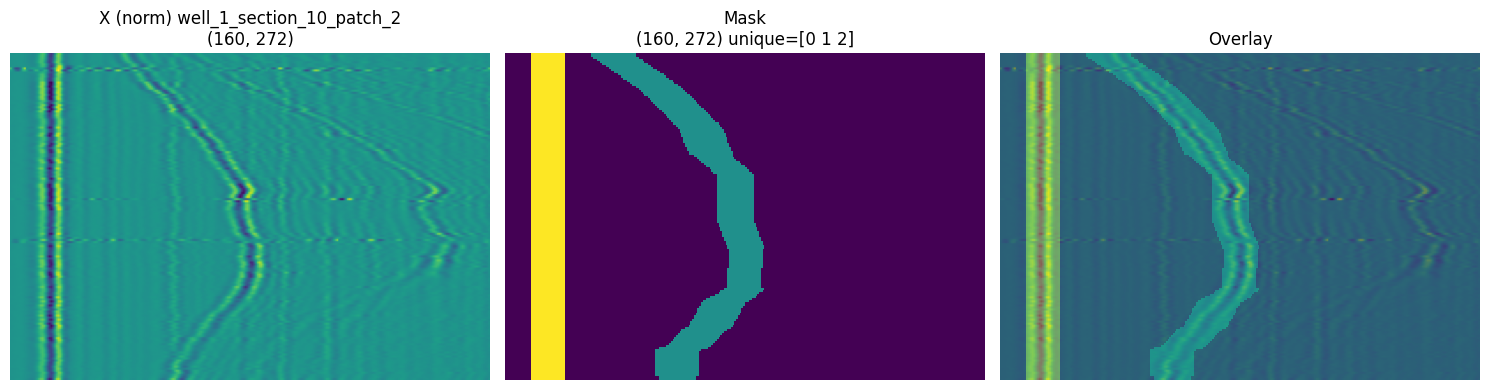

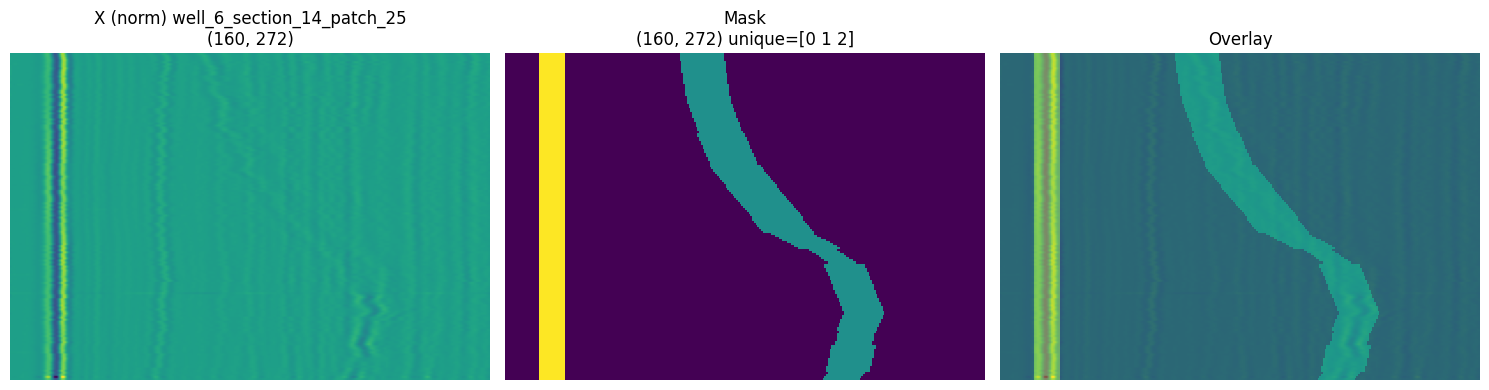

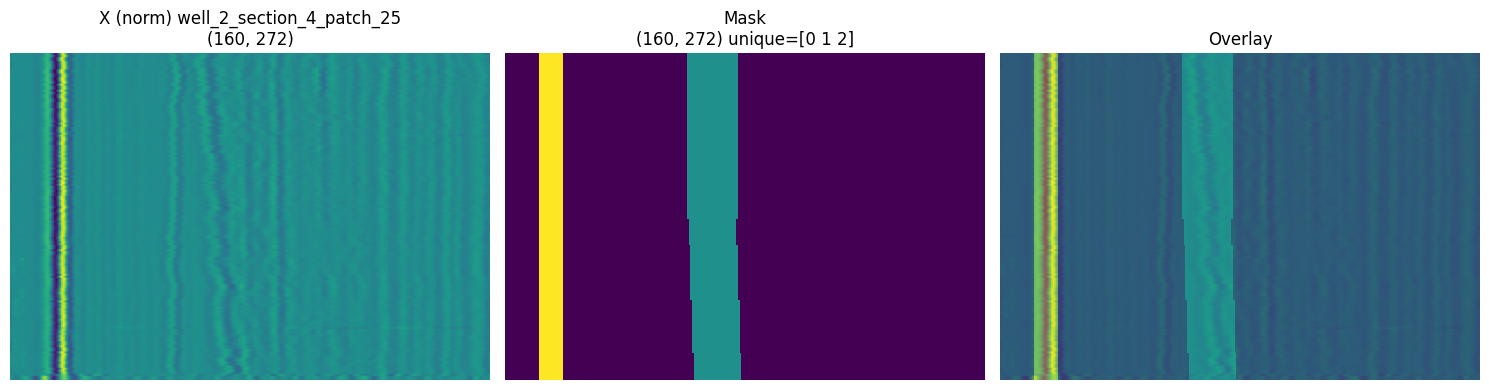

In [ ]:
# Cell 5 — 把 X 和 mask 叠在一起看（确认对齐/标注合理）
# 注意：这里假设 X_train 里确实有同名文件 name.npy
def show_overlay(name: str):
    x_path = X_TRAIN_DIR / f"{name}.npy"
    if not x_path.exists():
        # 如果文件在子目录，用 rglob 找一下
        matches = list(X_TRAIN_DIR.rglob(f"{name}.npy"))
        if len(matches) == 0:
            matches = list(X_TRAIN_DIR.rglob(f"{name}.NPY"))
        if len(matches) == 0:
            raise FileNotFoundError(f"Cannot find {name}.npy under X_TRAIN_DIR")
        x_path = matches[0]

    x = np.load(x_path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    xn = minmax_norm(x)

    m = restore_mask_from_row(y_df.loc[name].values)

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.title(f"X (norm) {name}\n{x.shape}")
    plt.imshow(xn, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Mask\n{m.shape} unique={np.unique(m)}")
    plt.imshow(m, aspect="auto", interpolation="nearest")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(xn, aspect="auto")
    plt.imshow(m, alpha=0.35, aspect="auto", interpolation="nearest")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# 抽几个有标签的样本看叠加
for name in random.sample(list(y_df.index), k=3):
    show_overlay(name)


found in first 2000 labels -> 160: 328  272: 1672


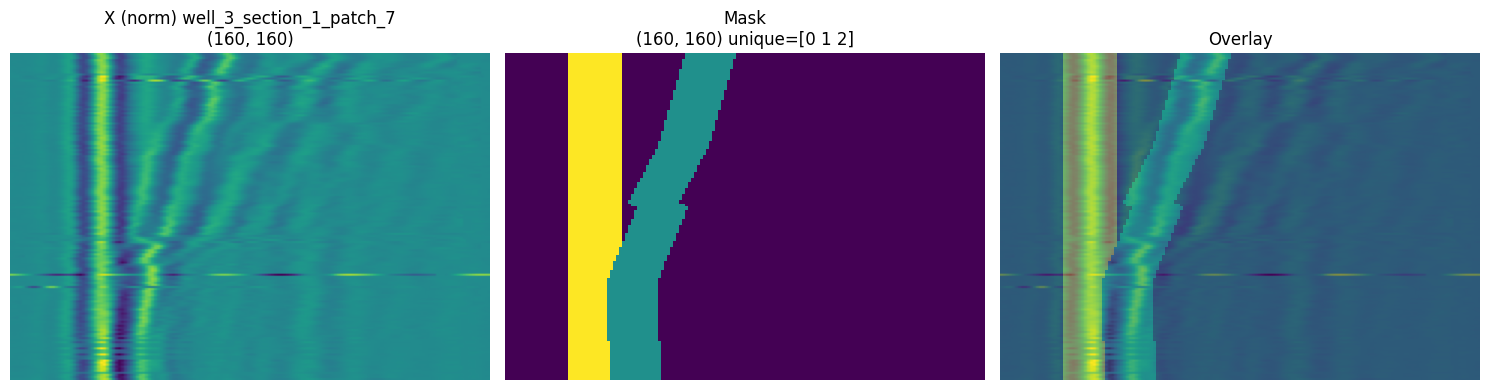

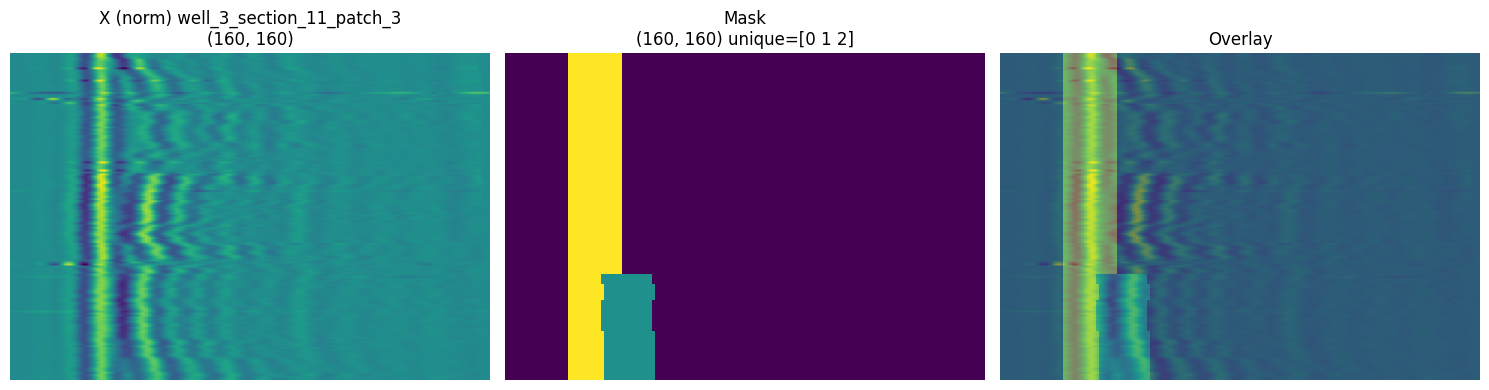

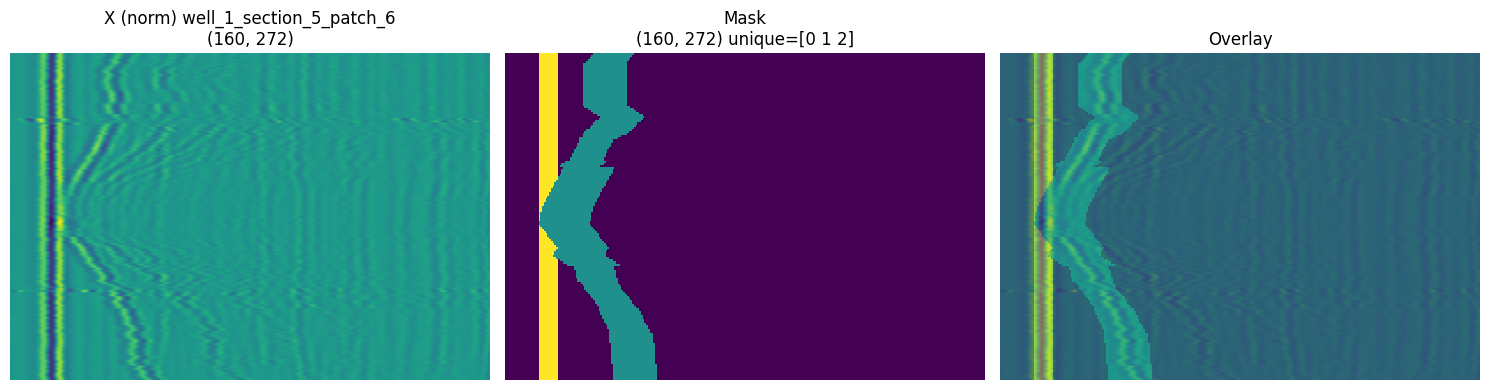

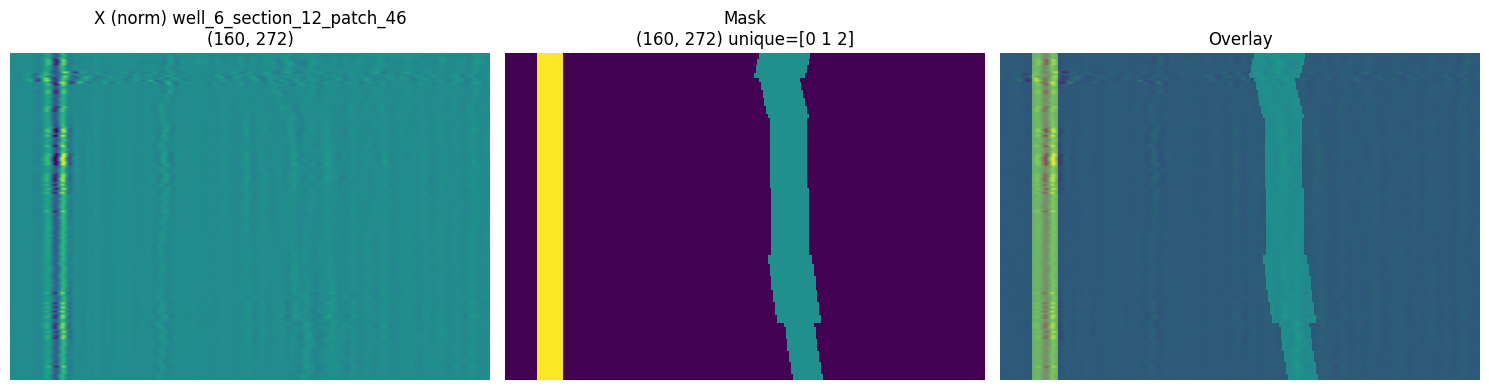

In [9]:
# Cell 6 — 看看 160×160 和 160×272 两种宽度各是什么样（各抽几张）
# 先从 y_train 里统计每个 patch 的 mask 宽度
def mask_width(name: str) -> int:
    m = restore_mask_from_row(y_df.loc[name].values)
    return int(m.shape[1])

names_160 = [n for n in y_df.index[:2000] if mask_width(n) == 160]
names_272 = [n for n in y_df.index[:2000] if mask_width(n) == 272]

print("found in first 2000 labels -> 160:", len(names_160), " 272:", len(names_272))

if len(names_160) > 0:
    for n in random.sample(names_160, k=min(2, len(names_160))):
        show_overlay(n)

if len(names_272) > 0:
    for n in random.sample(names_272, k=min(2, len(names_272))):
        show_overlay(n)


In [10]:
# Cell 7 — 全量统计：mask 宽度分布（160 vs 272）
from collections import Counter
import numpy as np
import pandas as pd

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]
    return vals.reshape(160, -1).astype(np.int64)

width_counter = Counter()
for name, row in y_df.iterrows():
    m = restore_mask_from_row(row.values)
    width_counter[m.shape[1]] += 1

width_counter


Counter({272: 3726, 160: 684})

In [11]:
# Cell 8 — 全量统计：类别像素占比 + patch-level presence（每类在多少patch里出现）
from collections import defaultdict

pixel_counts = defaultdict(int)     # label -> total pixels
presence_counts = defaultdict(int)  # label -> number of patches where label appears
n_patches = 0

for name, row in y_df.iterrows():
    m = restore_mask_from_row(row.values)
    n_patches += 1
    uniq = np.unique(m)
    for v in uniq:
        presence_counts[int(v)] += 1
    for v, c in zip(*np.unique(m, return_counts=True)):
        pixel_counts[int(v)] += int(c)

total_pixels = sum(pixel_counts.values())
stats = []
for k in sorted(pixel_counts.keys()):
    stats.append({
        "label": k,
        "total_pixels": pixel_counts[k],
        "pixel_ratio": pixel_counts[k] / total_pixels,
        "patch_presence": presence_counts[k],
        "presence_ratio": presence_counts[k] / n_patches
    })

class_stats_df = pd.DataFrame(stats).sort_values("label").reset_index(drop=True)
class_stats_df


,label,total_pixels,pixel_ratio,patch_presence,presence_ratio
0,0,153256840,0.853010,4410,1.000000
1,1,15970360,0.088889,4362,0.989116
2,2,10438720,0.058101,4410,1.000000


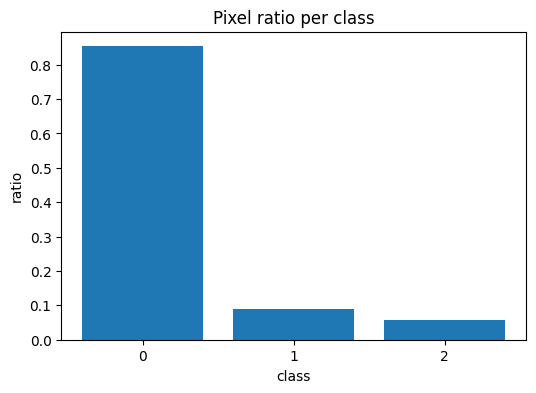

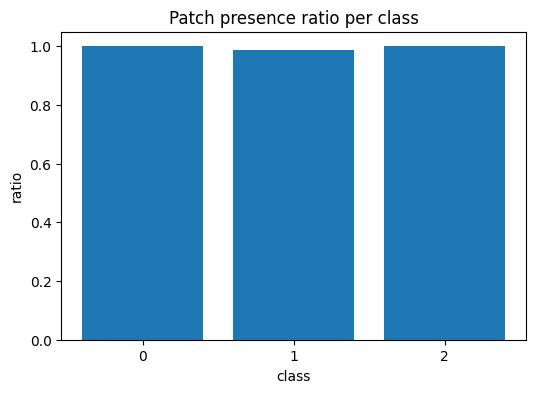

In [12]:
# Cell 9 — 可视化：像素占比柱状图（看类别不平衡程度）
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(class_stats_df["label"].astype(str), class_stats_df["pixel_ratio"])
plt.title("Pixel ratio per class")
plt.xlabel("class")
plt.ylabel("ratio")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(class_stats_df["label"].astype(str), class_stats_df["presence_ratio"])
plt.title("Patch presence ratio per class")
plt.xlabel("class")
plt.ylabel("ratio")
plt.show()


In [13]:
# Cell 10 — 按 well 统计：每口井有多少patch、以及两种宽度分别多少
def parse_well(name: str) -> int:
    # name like well_2_section_22_patch_1
    return int(name.split("_")[1])

well_counter = defaultdict(int)
well_width_counter = defaultdict(lambda: defaultdict(int))

for name in y_df.index:
    w = restore_mask_from_row(y_df.loc[name].values).shape[1]
    well = parse_well(name)
    well_counter[well] += 1
    well_width_counter[well][w] += 1

well_rows = []
for well in sorted(well_counter.keys()):
    wd = dict(well_width_counter[well])
    well_rows.append({
        "well": well,
        "n_patches": well_counter[well],
        "n_w160": wd.get(160, 0),
        "n_w272": wd.get(272, 0),
    })

pd.DataFrame(well_rows).sort_values("well")


,well,n_patches,n_w160,n_w272
0,1,666,0,666
1,2,1152,0,1152
2,3,486,486,0
3,4,198,198,0
4,5,288,0,288
5,6,1620,0,1620


In [14]:
# Cell 11 — 计算一个“建议的类别权重”（用于 Weighted CE），防止小类学不动
# 这里给一个常用做法：w_c = 1 / log(1.02 + p_c)
import numpy as np

eps = 1.02
p = class_stats_df.sort_values("label")["pixel_ratio"].values
weights = 1.0 / np.log(eps + p)
weights = weights / weights.mean()  # 归一化一下，方便训练稳定
weights


array([0.19459702, 1.18150312, 1.62389986])

In [15]:
# Cell 12 — 构建 manifest（name/well/w/path），并附上原始宽度
from pathlib import Path
import pandas as pd
import numpy as np
import re

X_TRAIN_DIR = Path(r"..\data\X_train_uDRk9z9")
Y_TRAIN_CSV = Path(r"..\data\Y_train_T9NrBYo.csv")

NAME_RE = re.compile(r"well_(\d+)_section_(\d+)_patch_(\d+)$")
def parse_name(stem: str):
    m = NAME_RE.match(stem)
    return int(m.group(1)), int(m.group(2)), int(m.group(3))

def build_manifest(x_dir: Path) -> pd.DataFrame:
    paths = sorted(list(x_dir.rglob("*.npy")))
    if len(paths) == 0:
        paths = sorted(list(x_dir.rglob("*.NPY")))
    rows = []
    for p in paths:
        stem = p.stem
        well, section, patch = parse_name(stem)
        arr = np.load(p, mmap_mode="r")
        if arr.ndim == 3 and arr.shape[0] == 1:
            h, w = int(arr.shape[1]), int(arr.shape[2])
        elif arr.ndim == 2:
            h, w = int(arr.shape[0]), int(arr.shape[1])
        else:
            raise ValueError(arr.shape)
        rows.append({"name": stem, "well": well, "section": section, "patch": patch, "h": h, "w": w, "path": str(p)})
    return pd.DataFrame(rows)

train_df = build_manifest(X_TRAIN_DIR)
y_df = pd.read_csv(Y_TRAIN_CSV, index_col=0)

# 对齐
train_df = train_df[train_df["name"].isin(y_df.index)].reset_index(drop=True)
print("aligned train_df:", train_df.shape, "y_df:", y_df.shape)
train_df["w"].value_counts()


aligned train_df: (4410, 7) y_df: (4410, 43520)


w
272    3726
160     684
Name: count, dtype: int64

In [16]:
# Cell 13 — 还原 mask + 生成 valid_mask（用于忽略 padding 区）
import numpy as np

IGNORE_INDEX = 255  # 或 -100 都行，只要和 loss 的 ignore_index 对上

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]
    return vals.reshape(160, -1).astype(np.int64)   # (160,160) or (160,272)

def pad_to_272(arr2d: np.ndarray, pad_value: int) -> np.ndarray:
    h, w = arr2d.shape
    if w == 272:
        return arr2d
    out = np.full((h, 272), pad_value, dtype=arr2d.dtype)
    out[:, :w] = arr2d
    return out

def make_valid_mask(w: int) -> np.ndarray:
    # True 表示有效区域（参与loss/metric）
    vm = np.zeros((160, 272), dtype=np.bool_)
    vm[:, :w] = True
    return vm

# quick check
name0 = train_df.loc[0, "name"]
w0 = int(train_df.loc[0, "w"])
m0 = restore_mask_from_row(y_df.loc[name0].values)
m0p = pad_to_272(m0, pad_value=0)
vm0 = make_valid_mask(w0)
print(name0, "orig_w=", w0, "mask:", m0.shape, "padded:", m0p.shape, "valid true=", vm0.sum())


well_1_section_0_patch_0 orig_w= 272 mask: (160, 272) padded: (160, 272) valid true= 43520


In [17]:
# Cell 14 — 读取 X + 预处理（keep272，160宽的右侧补0，但用 valid_mask 忽略）
import numpy as np

def load_x(path: str) -> np.ndarray:
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    # per-patch min-max
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        x = (x - mn) / (mx - mn)
    else:
        x = np.zeros_like(x, dtype=np.float32)
    return x  # (160, w)

def pad_x_to_272(x: np.ndarray) -> np.ndarray:
    h, w = x.shape
    if w == 272:
        return x
    out = np.zeros((h, 272), dtype=np.float32)
    out[:, :w] = x
    return out


In [18]:
# Cell 15 — Dataset：返回 (x, y, valid_mask, meta)
import torch
from torch.utils.data import Dataset, DataLoader

class SegDatasetKeep272(Dataset):
    def __init__(self, df: pd.DataFrame, y_df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.y_df = y_df

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        name = row["name"]
        w = int(row["w"])

        x = load_x(row["path"])           # (160,w)
        x = pad_x_to_272(x)               # (160,272)
        x_t = torch.from_numpy(x).unsqueeze(0)  # (1,160,272)

        m = restore_mask_from_row(self.y_df.loc[name].values)  # (160,w)
        m = pad_to_272(m, pad_value=0)                         # (160,272)
        valid = make_valid_mask(w)                             # (160,272)

        y = m.copy()
        y[~valid] = IGNORE_INDEX                               # padding 区忽略
        y_t = torch.from_numpy(y).long()
        valid_t = torch.from_numpy(valid)

        meta = {"name": name, "well": int(row["well"]), "orig_w": w}
        return x_t, y_t, valid_t, meta

# 先做一个按 well 的划分（示例：val 用 well=5；我们后面会做多折对比）
VAL_WELLS = {5}
train_split = train_df[~train_df["well"].isin(VAL_WELLS)].reset_index(drop=True)
val_split   = train_df[train_df["well"].isin(VAL_WELLS)].reset_index(drop=True)

train_loader = DataLoader(SegDatasetKeep272(train_split, y_df), batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(SegDatasetKeep272(val_split, y_df), batch_size=8, shuffle=False, num_workers=0)

x, y, valid, meta = next(iter(train_loader))
print("x:", x.shape, x.dtype, "y:", y.shape, y.dtype, "valid:", valid.shape, valid.dtype)
print("example meta:", meta["name"][0], meta["orig_w"][0], meta["well"][0])
print("ignore pixels in batch:", (y == IGNORE_INDEX).sum().item())


x: torch.Size([8, 1, 160, 272]) torch.float32 y: torch.Size([8, 160, 272]) torch.int64 valid: torch.Size([8, 160, 272]) torch.bool
example meta: well_2_section_1_patch_25 tensor(272) tensor(2)
ignore pixels in batch: 17920


In [20]:
# Cell 16 — 公用：IoU（支持 ignore_index）+ Dice + WeightedCE 组合损失
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

NUM_CLASSES = 3
IGNORE_INDEX = 255

# 来自你统计的像素占比：0=0.853010, 1=0.088889, 2=0.058101
# 用 1/log(eps+p) 生成权重（也可以改成 1/p）
def make_ce_weights(p, eps=1.02):
    p = np.array(p, dtype=np.float32)
    w = 1.0 / np.log(eps + p)
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

ce_weights = make_ce_weights([0.853010, 0.088889, 0.058101])
print("CE weights:", ce_weights)

class WeightedCELoss(nn.Module):
    def __init__(self, weights, ignore_index=IGNORE_INDEX):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights, ignore_index=ignore_index)
    def forward(self, logits, target):
        return self.ce(logits, target)

def soft_dice_loss(logits, target, num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, smooth=1.0):
    """
    logits: (B,C,H,W)
    target: (B,H,W) long, may contain ignore_index
    """
    B, C, H, W = logits.shape
    probs = torch.softmax(logits, dim=1)

    # mask ignore
    valid = (target != ignore_index).unsqueeze(1)  # (B,1,H,W)
    target_clamped = target.clone()
    target_clamped[target_clamped == ignore_index] = 0

    onehot = F.one_hot(target_clamped, num_classes=num_classes).permute(0,3,1,2).float()  # (B,C,H,W)

    probs = probs * valid
    onehot = onehot * valid

    dims = (0,2,3)
    inter = torch.sum(probs * onehot, dims)
    denom = torch.sum(probs + onehot, dims)
    dice = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

def mean_iou(pred, target, num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX):
    """
    pred/target: (B,H,W) long
    ignore_index 区域不计入 IoU
    """
    ious = []
    for c in range(num_classes):
        p = (pred == c)
        t = (target == c)
        valid = (target != ignore_index)
        p = p & valid
        t = t & valid
        inter = (p & t).sum().float()
        union = (p | t).sum().float()
        if union.item() == 0.0:
            ious.append(torch.tensor(1.0, device=pred.device))
        else:
            ious.append(inter / union)
    return torch.stack(ious).mean()

class ComboLoss(nn.Module):
    def __init__(self, ce_weights, dice_weight=0.5):
        super().__init__()
        self.ce = WeightedCELoss(ce_weights, ignore_index=IGNORE_INDEX)
        self.dice_weight = dice_weight
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        dice = soft_dice_loss(logits, target)
        return (1.0 - self.dice_weight) * ce + self.dice_weight * dice


CE weights: tensor([0.1946, 1.1815, 1.6239])


In [22]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3
IGNORE_INDEX = 255

print("DEVICE =", DEVICE)

DEVICE = cuda


In [23]:
# Cell 17 — Exp01 模型：UNet（输入1通道，输出3类），适配 160×272
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, num_classes=3, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)           # 160x272 -> 80x136
        self.enc2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)           # 80x136 -> 40x68
        self.enc3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)           # 40x68 -> 20x34

        self.bottleneck = DoubleConv(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)   # 20x34 -> 40x68
        self.dec3 = DoubleConv(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)   # 40x68 -> 80x136
        self.dec2 = DoubleConv(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)     # 80x136 -> 160x272
        self.dec1 = DoubleConv(base*2, base)

        self.head = nn.Conv2d(base, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.head(d1)

model = UNet(in_ch=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
print("UNet params:", sum(p.numel() for p in model.parameters())/1e6, "M")


UNet params: 1.927907 M


In [25]:
# Cell 18 — 训练循环（Exp01），保存 best，输出 val mIoU
from pathlib import Path
from tqdm import tqdm

OUT_ROOT = Path("./exp_outputs")
OUT_ROOT.mkdir(exist_ok=True)

def train_one_experiment(model, train_loader, val_loader, exp_name: str, epochs=30, lr=1e-3):
    exp_dir = OUT_ROOT / exp_name
    exp_dir.mkdir(parents=True, exist_ok=True)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = ComboLoss(ce_weights.to(DEVICE), dice_weight=0.5)

    best_miou = -1.0
    best_path = exp_dir / "best.pt"

    for ep in range(1, epochs+1):
        model.train()
        tr_loss = 0.0
        for x, y, valid, meta in tqdm(train_loader, desc=f"[{exp_name}] train ep{ep}", leave=False):
            x = x.to(DEVICE)  # (B,1,160,272)
            y = y.to(DEVICE)  # (B,160,272)
            logits = model(x)
            loss = loss_fn(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            tr_loss += loss.item() * x.size(0)
        tr_loss /= max(1, len(train_loader.dataset))

        model.eval()
        miou_sum = 0.0
        n = 0
        with torch.no_grad():
            for x, y, valid, meta in tqdm(val_loader, desc=f"[{exp_name}] val ep{ep}", leave=False):
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                logits = model(x)
                pred = torch.argmax(logits, dim=1)
                miou = mean_iou(pred, y)
                miou_sum += float(miou.item()) * x.size(0)
                n += x.size(0)
        val_miou = miou_sum / max(1, n)

        print(f"[{exp_name}] epoch {ep:02d}/{epochs}  train_loss={tr_loss:.4f}  val_mIoU={val_miou:.4f}")

        if val_miou > best_miou:
            best_miou = val_miou
            torch.save({"model": model.state_dict()}, best_path)

    print(f"[{exp_name}] best val mIoU={best_miou:.4f} saved to {best_path}")
    return best_path, best_miou, exp_dir

# 建议：先 epochs=10 快速验证流程是否正确；后面冲分再拉长
best_path, best_miou, exp_dir = train_one_experiment(
    model, train_loader, val_loader, exp_name="Exp01_UNet_keep272", epochs=10, lr=1e-3
)


[Exp01_UNet_keep272] epoch 01/10  train_loss=0.2039  val_mIoU=0.6081


[Exp01_UNet_keep272] epoch 02/10  train_loss=0.1130  val_mIoU=0.7172


[Exp01_UNet_keep272] epoch 03/10  train_loss=0.1055  val_mIoU=0.6679


[Exp01_UNet_keep272] epoch 04/10  train_loss=0.1030  val_mIoU=0.7256


[Exp01_UNet_keep272] epoch 05/10  train_loss=0.0974  val_mIoU=0.7711


[Exp01_UNet_keep272] epoch 06/10  train_loss=0.0933  val_mIoU=0.7719


[Exp01_UNet_keep272] epoch 07/10  train_loss=0.0930  val_mIoU=0.7371


[Exp01_UNet_keep272] epoch 08/10  train_loss=0.0917  val_mIoU=0.7755


[Exp01_UNet_keep272] epoch 09/10  train_loss=0.0899  val_mIoU=0.7718


[Exp01_UNet_keep272] epoch 10/10  train_loss=0.0881  val_mIoU=0.7652
[Exp01_UNet_keep272] best val mIoU=0.7755 saved to exp_outputs\Exp01_UNet_keep272\best.pt


In [27]:
# Cell 19 — Exp01：对 X_test 预测，保存每个 patch 的 .npy（原始宽度160或272）并生成提交 CSV
from pathlib import Path
import numpy as np
import pandas as pd
import torch

X_TEST_DIR  = Path(r"..\data\X_train_uDRk9z9")

def build_test_manifest(x_dir: Path) -> pd.DataFrame:
    paths = sorted(list(x_dir.rglob("*.npy")))
    if len(paths) == 0:
        paths = sorted(list(x_dir.rglob("*.NPY")))
    rows = []
    for p in paths:
        stem = p.stem
        well, section, patch = parse_name(stem)
        arr = np.load(p, mmap_mode="r")
        if arr.ndim == 3 and arr.shape[0] == 1:
            h, w = int(arr.shape[1]), int(arr.shape[2])
        elif arr.ndim == 2:
            h, w = int(arr.shape[0]), int(arr.shape[1])
        else:
            raise ValueError(arr.shape)
        rows.append({"name": stem, "well": well, "section": section, "patch": patch, "h": h, "w": w, "path": str(p)})
    return pd.DataFrame(rows)

test_df = build_test_manifest(X_TEST_DIR)

def pad_x_to_272(x: np.ndarray) -> np.ndarray:
    h, w = x.shape
    if w == 272:
        return x
    out = np.zeros((h, 272), dtype=np.float32)
    out[:, :w] = x
    return out

def preprocess_x(path: str) -> np.ndarray:
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        x = (x - mn) / (mx - mn)
    else:
        x = np.zeros_like(x, dtype=np.float32)
    return x  # (160,w)

# load best
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

pred_dir = exp_dir / "test_predictions"
pred_dir.mkdir(parents=True, exist_ok=True)

# 逐个patch预测（简单稳妥；后续可做 batch 加速）
with torch.no_grad():
    for _, row in test_df.iterrows():
        name = row["name"]
        w = int(row["w"])
        x = preprocess_x(row["path"])
        x = pad_x_to_272(x)                           # (160,272)
        x_t = torch.from_numpy(x).unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,160,272)
        logits = model(x_t)
        pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy().astype(np.int64)  # (160,272)
        pred = pred[:, :w]                            # 恢复原宽度（160或272）
        np.save(pred_dir / f"{name}.npy", pred)

print("saved npy predictions to:", pred_dir)

# === 按你给的官方方式生成 CSV ===
size_labels = 272
predictions = {'test': {}}
img_save_dir = pred_dir

for img_path in img_save_dir.glob('*.npy'):
    name = img_path.stem
    if name in predictions['test']:
        continue
    prediction = np.load(img_path)  # (160,160) or (160,272)
    if prediction.shape[1] != size_labels:
        prediction_aux = -1 + np.zeros(160 * size_labels, dtype=np.int64)
        prediction_aux[0:160 * 160] = prediction.flatten()
    else:
        prediction_aux = prediction.flatten().astype(np.int64)
    predictions['test'][name] = prediction_aux

sub_path = exp_dir / "y_test_submission.csv"
pd.DataFrame(predictions['test'], dtype='int').T.to_csv(sub_path)
print("saved submission csv to:", sub_path)


C:\Users\asus\AppData\Local\Temp\ipykernel_4260\3674818593.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=DEVICE)


saved npy predictions to: exp_outputs\Exp01_UNet_keep272\test_predictions
saved submission csv to: exp_outputs\Exp01_UNet_keep272\y_test_submission.csv


In [9]:
import pandas as pd

sub = pd.read_csv(Path(r"..\data\submission_csv_file_random_example_3qPSCtv.csv"))
sub.loc[0]

Unnamed: 0    well_7_section_21_patch_4
0                                     0
1                                     0
2                                     0
3                                     0
                        ...            
43515                                 0
43516                                 0
43517                                 0
43518                                 0
43519                                 0
Name: 0, Length: 43521, dtype: object